In [1]:
# Load required packages

from __future__ import print_function, division
import SNIDsn
import SNIDdataset as snid
import numpy as np
import SNePCA

import plotly.plotly as ply
import plotly.graph_objs as go
import plotly.tools as tls

import matplotlib.pyplot as plt

import pandas
import scipy
from statistics import mean

In [2]:
# Load pickled data

dataset0 = snid.loadPickle('../Data/DataProducts/dataset0.pickle')
dataset5 = snid.loadPickle('../Data/DataProducts/dataset5.pickle')
dataset10 = snid.loadPickle('../Data/DataProducts/dataset10.pickle')
dataset15 = snid.loadPickle('../Data/DataProducts/dataset15.pickle')

In [17]:
# Wavelength, Flux and Uncertainty arrays for supernova 'sn2004gq'.

wvl = dataset15["sn2009iz"].wavelengths
y_11hs = dataset15["sn2009iz"].data
flux = y_11hs.astype('float64')
uncer = dataset15["sn2009iz"].smooth_uncertainty['Ph12.9']

In [ ]:
# Summing uncertainties in non-integer bins.
def nonintuncer(uncer, N):
    N1 = int(N)
    n = N - N1
    n2 = N - N1
    i = 0
    newbins = []
    newbins.append(np.sum(np.square(uncer[i:i + N1])) + np.square(n * uncer[i + N1]))
    while i < len(uncer) - np.ceil(N) - N1:
        i = i + N1
        N1 = int(N - (1 - n)) + 1
        newbins.append(np.square((1 - n) * uncer[i]))
        n = N - (N1 - 1 + (1 - n))
        newbins[-1] += np.sum(np.square(uncer[i + 1:i + N1])) + np.square(n * uncer[i + N1])
    return np.sqrt(newbins)

In [ ]:
# Summing flux in Non-integer bins.
def nonintflux(flux, N):
    N1 = int(N)
    n = N - N1
    n2 = N - N1
    i = 0
    newbins = []
    newbins.append(flux[i:i + N1].sum() + n * flux[i + N1]) 
    #print(newbins)
    while i < len(flux) - np.ceil(N) - N1:
        #print(i, N1)
        i = i + N1
        N1 = int(N - (1 - n)) + 1
        newbins.append((1 - n) * flux[i])
        n = N - (N1 - 1 + (1 - n))
        print(i, N1, n)
        #print(n)
        #print(1-n)
        newbins[-1] += flux[i + 1:i + N1].sum() + n * flux[i + N1]
    return np.array(newbins)

In [ ]:
# The function that takes in old wavelength bins and give back the new reduced resolution bins by
# any non-integer factor N.
def nonintwavbins(wvl, N):
    N1 = int(N)
    N3 = int(N)
    n = N - N1
    n0 = N - N1
    N2 = int(np.ceil(N))
    i = 0
    k = 0
    obl = wvl[i+1] - wvl[i]
    obr = float(obl)/2
    nbl = obl*N
    nbr = float(nbl)/2
    brdiff = nbr - obr
    newbins = []
    nbnctr = wvl[i] + brdiff
    newbins.append(nbnctr)
    while i < len(wvl) - np.ceil(N) - N1:
        i = i + N1
        k = k + N3
        obl = wvl[i+1] - wvl[i]
        obr = float(obl)/2
        nbl = obl*N
        nbr = float(nbl)/2
        brdiff = nbr - obr
        N1 = int(N - (1 - n)) + 1
        N3 = int(N - (1 - n0)) + 1
        n0 = N - (N1 - n0)
        nbnctr +=  (1 - n) * (wvl[i+1] - wvl[i])  + wvl[i + N1] - wvl[i + 1] + n0 * (wvl[i + N1] - wvl[i + N1 - 1])
        newbins.append(nbnctr)
        n = N - (N1 - n)
    return np.array(newbins)

In [18]:
# Function that reduces the resolution of a given spectrum by any non-integer number N. It takes 
# wavelength, flux and uncertainty arrays as input and gives back the new wavelength, flux and uncertainty arrays
# of the reduced resolution spectrum.

def nonintspecres(wvl, flux, uncer, N):
    N1 = int(N)
    N3 = int(N)
    n = N - N1
    n0 = N - N1
    N2 = int(np.ceil(N))
    i = 0
    k = 0
    obl = wvl[i+1] - wvl[i]
    obr = float(obl)/2
    nbl = obl*N
    nbr = float(nbl)/2
    brdiff = nbr - obr
    newbins = []
    newflux = []
    newuncer = []
    nbnctr = wvl[i] + brdiff
    newbins.append(nbnctr)
    newflux.append(flux[i:i + N1].sum() + n * flux[i + N1])
    newuncer.append(np.sqrt(np.sum(np.square(uncer[i:i + N1])) + np.square(n * uncer[i + N1])))
    while i < len(wvl) - np.ceil(N) - N1:
        i = i + N1
        k = k + N3
        obl = wvl[i+1] - wvl[i]
        obr = float(obl)/2
        nbl = obl*N
        nbr = float(nbl)/2
        brdiff = nbr - obr
        N1 = int(N - (1 - n)) + 1
        N3 = int(N - (1 - n0)) + 1
        n0 = N - (N1 - n0)
        nbnctr +=  (1 - n) * (wvl[i+1] - wvl[i])  + wvl[i + N1] - wvl[i + 1] + n0 * (wvl[i + N1] - wvl[i + N1 - 1])
        newbins.append(nbnctr)
        newflux.append((1 - n) * flux[i] + flux[i + 1:i + N1].sum() + n0 * flux[i + N1])
        newuncer.append(np.sqrt(np.square((1 - n) * uncer[i]) + np.sum(np.square(uncer[i + 1:i + N1])) + np.square(n0 * uncer[i + N1])))
        n = N - (N1 - n)
    return np.array(newbins), np.array(newflux), np.array(newuncer)

In [19]:
newspectra = nonintspecres(wvl, flux, uncer, 10.3)

In [20]:
newspectra[0].shape, newspectra[1].shape, newspectra[2].shape

((40,), (40,), (40,))

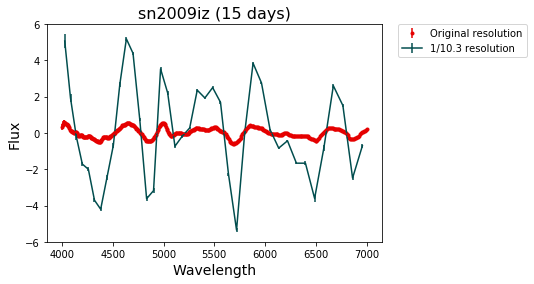

In [22]:
# Spectrum of "X" with the uncertainty.

plt.errorbar(wvl, flux, c='xkcd:red',yerr=uncer, xerr=None,
             fmt='.', ecolor=None, elinewidth=None, capsize=None, 
             barsabove=True, lolims=False, uplims=False, xlolims=False, 
             xuplims=False, errorevery=1, capthick=None, data=None, label="Original resolution")
plt.errorbar(newspectra[0], newspectra[1], c='xkcd:dark teal',yerr=newspectra[2], 
             xerr=None, fmt='', ecolor=None, elinewidth=None, capsize=None, barsabove=True, 
             lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None, 
             data=None, label="1/10.3 resolution")
plt.xlabel('Wavelength', fontsize=14)
plt.ylabel('Flux', fontsize=14)
plt.title('sn2009iz (15 days)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#plt.xlim(4550, 5000)
#plt.ylim(-0.1, 0.1)
plt.show()